## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from Common import NeuralNet, MultiVariatePoly
import time
torch.manual_seed(128)

Consider the porous 2D incompressible steady-state Stokes equation:
$\newcommand{\Reynolds}{\text{Re}}\renewcommand{\div}{\text{div}}$
$$
 -\nabla \hat{p} + \div(\frac{2}{\Reynolds} \epsilon(\hat{u}))
 -\frac{1}{\Reynolds} \left(\frac{5L^2}{2H_t^2} + \hat{\alpha}(\rho)\right) \hat{u} = 0
$$
$$
\div(\hat{u})= 0
$$

with constant inflow and boundary conditions
$$
u_b(0,y) = \text{const} u_{in}
$$

$$
u_b(x,0)=u_b(x,1)=0, 
$$

We want to obtain an approximate solution of $u : [0,1]\times[0,1] \mapsto \mathbb{R}^2$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(x,y) \approx u(x,y)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,0,\theta}(x, y):= -\nabla \hat{p} + \div(\frac{2}{\Reynolds} \epsilon(\hat{u}))
 -\frac{1}{\Reynolds} \left(\frac{5L^2}{2H_t^2} + \hat{\alpha}(\rho)\right) \hat{u}$$
   $$r_{int,1,\theta}(x, y):= \div(\hat{u})$$
   
   - inflow boundary residual given by,
   
        $$r_{ib,\theta}(x,y):= u_{\theta}(x,y)- u_in$$
        
   - outside boundary residual given by,
   
        $$r_{ob,\theta}(x,0):= u_{\theta}(x,0), r_{ob, \theta}(x,1) := u_{\theta}(x,1) \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int,0}(\theta) = \int_{[0,1]\times[0,1]}r_{int,0,\theta}^2(x, y) dxdy, \quad
L_{int,1}(\theta) = \int_{[0,1]\times[0,1]}r_{int,1,\theta}^2(x, y) dxdy, \quad
L_{ib}(\theta) = \int_{[0,1]}r_{ib,\theta}^2(0,y) dy, \quad
L_{ob}(\theta) = \int_{[0,1]}r_{ob,\theta}^2(x,0) dx + \int_{[0,1]}r_{ob,\theta}^2(x,1) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{z_n\}, \quad 1 \leq n \leq N_{int},\quad z_n = (x,y)_n \in D_T,
$$

$$
S_{ib} =\{y_n, u_b(0,y_n) \}, \quad1 \leq n \leq N_{ib}, y_n \in [0,1],
$$

$$
S_{ob, 0}=\{x_n, u_0(x_n,0)\}\quad  1 \leq n \leq N_{ob}, x_n \in [0,1].
$$

$$
S_{ob, 1}=\{x_n, u_0(x_n,1)\}\quad  1 \leq n \leq N_{ob}, x_n \in [0,1].
$$


with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int,0}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,1,\theta}^2(z_n) , \quad
L_{int,1}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,1,\theta}^2(z_n) , \quad
L_{ib}(\theta) = \frac{1}{N_{ib}}\sum_{i=1}^{N_{ib}}r_{sb,\theta}^2(y_n,0)\quad
L_{ob}(\theta) = \frac{1}{N_{ob}}\sum_{i=1}^{N_{ob}}r_{ob,\theta}^2(x_n,0) +\frac{1}{N_{ob}}\sum_{i=1}^{N_{ob}}r_{ob,\theta}^2(x_n,1)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_{int} = L_{int,0} + L_{int,1}, \quad
L_u = L_{ib}(\theta) + L_{ob}(\theta)
$$



In [2]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) + model.regularization()
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [3]:
class Pinns:
    def __init__(self, n_int_, n_ib_, n_ob_):
        self.n_int = n_int_
        self.n_ib = n_ob_
        self.n_ob = n_ib_

        # Extrema of the solution domain (x,y) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],[0, 1]])

        # Number of space dimensions
        self.space_dimensions = 2

        # Parameter to balance role of data and PDE
        self.lambda_u = 10
        
        self.T_inlet = 293.15  # K

        self.channel_thickness = 380e-6  # m
        self.Ht = 0.5 * self.channel_thickness

        self.substrate_thickness = 150e-6  # m
        self.Hs = 0.5 * self.substrate_thickness

        self.conductivity_fluid = 0.598
        self.conductivity_substrate = 149
        self.viscosity_fluid = 1.004e-3
        self.capacity_fluid = 4180
        self.density_fluid = 998

        self.applied_pressure = 100000 * 5.0 / 4.0  # kg m^-1 s^-2
        self.L = 0.001  # m
        self.U = np.sqrt(self.applied_pressure / self.density_fluid)  # m/s


        self.nu = self.viscosity_fluid / self.density_fluid
        self.rho = self.load_rho()

        self.Re = self.L * self.U / self.nu
        #Prandtl_number = fd.Constant(capacity_fluid * viscosity_fluid / conductivity_fluid)
        self.nondim_Ht = self.Ht / self.L
        self.nondim_Hs = self.Hs / self.L
        
        self.qk = 1 #this change in each optimization steps
        self.alpha_f = 0
        self.alpha_s = 5*self.L**2/(2*self.Ht**2)

        # F Dense NN to approximate the solution of the underlying equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=3,
                                              n_hidden_layers=3,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        

        # Training sets S_ib, S_ob, S_int as torch dataloader
#         self.training_set_ib, self.training_set_ob, self.training_set_int, self.training_set_pb = self.assemble_datasets()
        self.training_set_ib, self.training_set_ob, self.training_set_int  = self.assemble_datasets()

    def load_rho(self):
        file_path = "/home/team/CAMLab-DLSCTutorials/"
        #file_path = "C:\\Users\\bonvi\\Documents\\simulation_hack\\simulation_hackaton_eth-rafael\\simulation_hackaton_eth-rafael\\formatted_data0\\"
        file = file_path + 'results-0.h5_rhof.out'
        rho = np.zeros((100,100))
        rho[:, 40:60] = np.full(rho[:, 40:60].shape, 1)
        return rho
        #return np.loadtxt(file)

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the inflow boundary condition
    def initial_condition(self, x):
        return np.array([1,0])


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_ib corresponding to the vertical boundary
    def add_inflow_boundary_points(self):
        #y0 = self.domain_extrema[0,1]
        input_ib = self.convert(self.soboleng.draw(self.n_ib))
        input_ib[:, 0] = torch.full(input_ib[:, 0].shape, 0)
#         output_ib = self.initial_condition(input_ib[:, 1]).reshape(-1, 1)  # reshape to [64, 1]
        output_ib = torch.clone(input_ib)
        output_ib[:,0] = torch.full(output_ib[:,0].shape,1)
        output_ib[:,1] = torch.full(output_ib[:,1].shape,0)
    
#         output_ib = self.initial_condition(input_ib[:, 1]).reshape(-1, 1)
        #print("Shape of input_ib[:, 1]:", input_ib[:, 1].shape)
        #print("Shape of output_ib:", output_ib.shape)


        return input_ib, output_ib

    # Function returning the input-output tensor required to assemble the training set S_ob corresponding to the horizontal boundary
    def add_horizontal_boundary_points(self):

        input_ob = self.convert(self.soboleng.draw(self.n_ob))

        input_ob_0 = torch.clone(input_ob)
        input_ob_0[:, 1] = torch.full(input_ob_0[:, 1].shape, 0)

        input_ob_L = torch.clone(input_ob)
        input_ob_L[:, 1] = torch.full(input_ob_L[:, 1].shape, 1)

        output_ob_0 = torch.clone(input_ob)
        output_ob_0[:, 0] = torch.full(output_ob_0[:, 0].shape, 0)
        output_ob_0[:, 1] = torch.full(output_ob_0[:, 1].shape, 0)
        output_ob_L = torch.clone(input_ob)
        output_ob_L[:, 0] = torch.full(output_ob_L[:, 0].shape, 0)
        output_ob_L[:, 1] = torch.full(output_ob_L[:, 1].shape, 0)

        return torch.cat([input_ob_0, input_ob_L], 0), torch.cat([output_ob_0, output_ob_L], 0)
    
    # Function returning the input-output tensor required to assemble the training set S_ib corresponding to the vertical boundary
    def add_exit_boundary_points(self):
        input_eb = self.convert(self.soboleng.draw(self.n_eb))
        input_eb[:, 0] = torch.full(input_eb[:, 0].shape, 1)
#         output_ib = self.initial_condition(input_ib[:, 1]).reshape(-1, 1)  # reshape to [64, 1]
        output_eb = torch.clone(input_ib)
        output_eb[:,0] = torch.full(output_eb[:,0].shape,0)
    
#         output_ib = self.initial_condition(input_ib[:, 1]).reshape(-1, 1)
        #print("Shape of input_ib[:, 1]:", input_ib[:, 1].shape)
        #print("Shape of output_ib:", output_ib.shape)


        return input_eb, output_eb
        
    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int
    

    # Function returning the training sets S_ib, S_ob, S_int as dataloader
    def assemble_datasets(self):
        input_ib, output_ib = self.add_inflow_boundary_points()  # S_ib
        input_ob, output_ob = self.add_horizontal_boundary_points()   # S_ob
        input_int, output_int = self.add_interior_points()         # S_int
#         input_pb, output_pb =self.add_p_points()

#         training_set_ib = DataLoader(torch.utils.data.TensorDataset(input_ib, output_ib), shuffle=False)
#         training_set_ob = DataLoader(torch.utils.data.TensorDataset(input_ob, output_ob), shuffle=False)
#         training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), shuffle=False)
        training_set_ib = DataLoader(torch.utils.data.TensorDataset(input_ib, output_ib), batch_size=self.n_ib, shuffle=False)
        training_set_ob = DataLoader(torch.utils.data.TensorDataset(input_ob, output_ob), batch_size=2*self.n_ob, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
#         training_set_p = DataLoader(torch.utils.data.TensorDataset(input_pb, output_pb), batch_size=self.n_int, shuffle=False)
        return training_set_ib, training_set_ob, training_set_int #, training_set_p

    ################################################################################################
    # Function to compute the terms required in the definition of the INFLOW boundary residual
    def apply_inflow_condition(self, input_ib):
        u_pred_ib = self.approximate_solution(input_ib)#[:,0:2]
        return u_pred_ib

    # Function to compute the terms required in the definition of the HORIZONTAL boundary residual
    def apply_boundary_conditions(self, input_ob):
        u_pred_ob = self.approximate_solution(input_ob)#[:,0:2]

        return u_pred_ob

    def alpha(self,rho):
        return (1-rho)/(1+self.qk*rho)*(self.alpha_s - self.alpha_f)+self.alpha_f
    
    def interpolate_rho(self,input_int):
        input_int = (input_int.detach().numpy() * 100).astype(int)
        rho = np.zeros((input_int.shape[0],1))
        for i in range(input_int.shape[0]):
            x = input_int[i,0]
            y = input_int[i,1]
            rho[i] = self.rho[x,y]
        return torch.Tensor(rho)
        
    def compute_pde_residual(self, input_int):
        rho = self.interpolate_rho(input_int)
        input_int.requires_grad = True # save gradients
        
        u = self.approximate_solution(input_int)[:,0:2]
        p = self.approximate_solution(input_int)[:,2] 

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        #print(grad_u[0].shape)
        #grad_u = grad_u[0]
        grad_u_x = grad_u[:, 0]
        grad_u_y = grad_u[:, 1]
        #grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 0]
        #grad_u_xx_y = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        #grad_u_yy = torch.autograd.grad(grad_u_y.sum(), input_int, create_graph=True)[0][:, 1]
        #grad_u_yy_x = torch.autograd.grad(grad_u_y.sum(), input_int, create_graph=True)[0][:, 0]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0]
        grad_u_yy = torch.autograd.grad(grad_u_y.sum(), input_int, create_graph=True)[0]


        grad_p = torch.autograd.grad(p.sum(), input_int, create_graph=True)[0]

        
        nabla_p = grad_p
        #div_term = 2*self.Re*(torch.concat((grad_u_xx + grad_u_yy_x, grad_u_xx_y + grad_u_yy))).reshape(-1,2)
        div_term = 2*self.Re*(torch.concat((torch.sum(grad_u_xx, dim=1),torch.sum(grad_u_yy, dim =1)))).reshape(-1,2)
        drag_term = 1/self.Re * (5 * self.L**2 / (2 * self.Ht**2) + self.alpha(rho)) * u
        
        residual = -nabla_p + div_term - drag_term
        return residual.reshape(-1, )
    
    
    # Function to compute the incompressibility term residuals on the interior
    def compute_incompress_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)[:,0:2]

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_x = grad_u[:, 0]
        grad_u_y = grad_u[:, 1]
        div_u = grad_u_x + grad_u_y
    
        return div_u.reshape(-1, )

    # Function to compute the total loss (weighted sum of inflow boundary loss, horizontal boundary loss and interior loss)
    def compute_loss(self, inp_train_ib, u_train_ib, inp_train_ob, u_train_ob, inp_train_int, verbose=True):
        u_pred_ib = self.apply_inflow_condition(inp_train_ib)[:,0:2]
        u_pred_ob = self.apply_boundary_conditions(inp_train_ob)[:,0:2]
#         p_pred_ib = self.apply_inflow_condition(inp_train_ib)[:,3]
#         p_pred_pb = self.apply_inflow_condition(inp_train_pb)[:,3]
        #p_pred_ob = self.apply_boundary_condition(inp_train_ob)[:,2:4]
        
#         print("Shape of u_pred_ib", u_pred_ib.shape)
#         print("Shape of u_train_ib:", u_train_ib.shape)
        #print("Shape of u_pred_ob", u_pred_ob.shape)
        #print("Shape of u_train_ob:", u_train_ob.shape)
        


        assert (u_pred_ib.shape[1] == u_train_ib.shape[1])
        assert (u_pred_ob.shape[1] == u_train_ob.shape[1])
        #assert (p_pred_ib.shape[1] == u_train_ib.shape[1])
        #assert (p_pred_ob.shape[1] == u_train_ob.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_inc = self.compute_incompress_residual(inp_train_int)
        r_ib = u_train_ib - u_pred_ib
        r_ob = u_train_ob - u_pred_ob
#         r_ib_p = u_train_ib - p_pred_ib
#         r_pb = u_train_pb - p_pred_pb
        #r_ob_p = u_train_ob - p_pred_ob

        loss_ib = torch.mean(abs(r_ib) ** 2)
        loss_ob = torch.mean(abs(r_ob) ** 2)
#         loss_ib_p = torch.mean(abs(r_ib_p) ** 2)
#         loss_pb = torch.mean(abs(r_pb) **2)
        #loss_ob_p = torch.mean(abs(r_ob_p) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_inc = torch.mean(abs(r_inc) ** 2)

        
        loss_u =  loss_ib + loss_ob
#         loss_p = loss_ib_p + loss_pb#+ loss_ob_p

        loss = torch.log10(self.lambda_u * (loss_u) + loss_int + loss_inc)
        #loss = loss_u  + loss_p
        if verbose: print("Total loss: ", round(loss.item(), 3), "| PDE Loss: ", round(torch.log10(loss_u).item(), 3), "| Function Loss: ", round(torch.log10(loss_int + loss_inc).item(), 3))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")
            for j, ((inp_train_ib, u_train_ib), (inp_train_ob, u_train_ob), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_ib, self.training_set_ob, self.training_set_int)):

#             for j, ((inp_train_ib, u_train_ib), (inp_train_ob, u_train_ob), (inp_train_int, u_train_int), (inp_train_pb, u_train_pb)) in enumerate(zip(self.training_set_ib, self.training_set_ob, self.training_set_int, self.training_set_pb)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_ib, u_train_ib, inp_train_ob, u_train_ob, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        #inputs = self.convert(inputs)

        output_ux = self.approximate_solution(inputs)[:,0].reshape(-1, )
        output_uy = self.approximate_solution(inputs)[:,1].reshape(-1, )
        output_p = self.approximate_solution(inputs)[:,2].reshape(-1, )
#         output_py = self.approximate_solution(inputs)[:,3].reshape(-1, )
#         exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].tripcolor(inputs[:, 0].detach(), inputs[:, 1].detach(), output_ux.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].tripcolor(inputs[:, 0].detach(), inputs[:, 1].detach(), output_uy.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[1].set_title("u_y")
        axs[0].set_title("u_x")

        plt.show()
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].tripcolor(inputs[:, 0].detach(), inputs[:, 1].detach(), output_p.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        axs[0].set_title("p")

        plt.show()

#         err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
#         print("L2 Relative Error Norm: ", err.item(), "%")


In [4]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

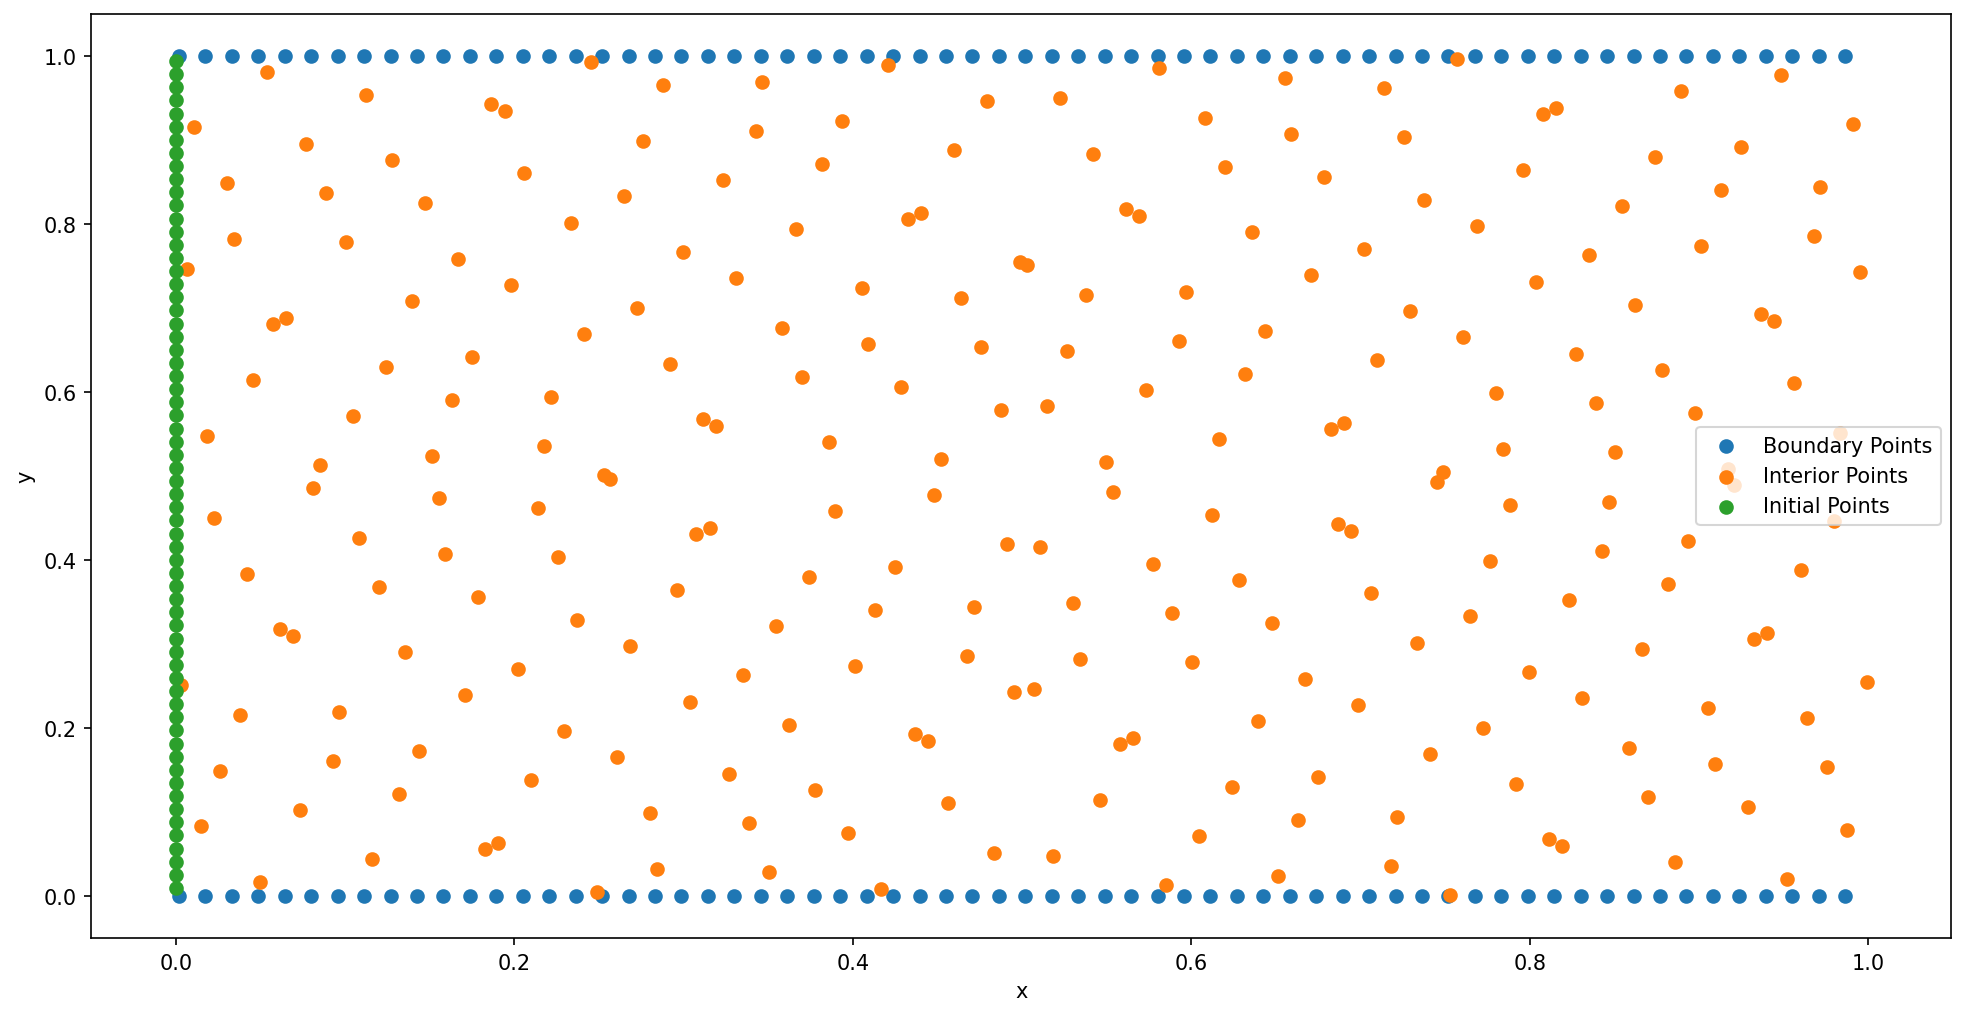

In [5]:
# Plot the input training points
input_ib_, output_ib_ = pinn.add_inflow_boundary_points()
input_ob_, output_ob_ = pinn.add_horizontal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_ob_[:, 0].detach().numpy(), input_ob_[:, 1].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 0].detach().numpy(), input_int_[:, 1].detach().numpy(), label="Interior Points")
plt.scatter(input_ib_[:, 0].detach().numpy(), input_ib_[:, 1].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  10.056 | PDE Loss:  0.078 | Function Loss:  10.056
Total loss:  9.981 | PDE Loss:  0.012 | Function Loss:  9.981
Total loss:  9.481 | PDE Loss:  -0.259 | Function Loss:  9.481
Total loss:  9.269 | PDE Loss:  -0.202 | Function Loss:  9.269
Total loss:  9.274 | PDE Loss:  0.405 | Function Loss:  9.274
Total loss:  8.964 | PDE Loss:  0.201 | Function Loss:  8.964
Total loss:  8.77 | PDE Loss:  -0.204 | Function Loss:  8.77
Total loss:  8.625 | PDE Loss:  -0.331 | Function Loss:  8.625
Total loss:  8.176 | PDE Loss:  -0.189 | Function Loss:  8.176
Total loss:  9.535 | PDE Loss:  0.694 | Function Loss:  9.535
Total loss:  8.101 | PDE Loss:  0.004 | Function Loss:  8.101
Total loss:  7.911 | PDE Loss:  -0.046 | Function Loss:  7.911
Total loss:  7.775 | PDE Loss:  -0.184 | Function Loss:  7.775
Total loss:  7.623 | PDE Loss:  -0.165 | Function Loss:  7.623
Total loss:  7.44 | PDE Loss:  -0.097 | Function Loss:

Total loss:  2.533 | PDE Loss:  -0.102 | Function Loss:  2.522
Total loss:  2.526 | PDE Loss:  -0.099 | Function Loss:  2.515
Total loss:  2.518 | PDE Loss:  -0.096 | Function Loss:  2.508
Total loss:  2.508 | PDE Loss:  -0.094 | Function Loss:  2.497
Total loss:  2.498 | PDE Loss:  -0.092 | Function Loss:  2.487
Total loss:  2.485 | PDE Loss:  -0.093 | Function Loss:  2.474
Total loss:  2.474 | PDE Loss:  -0.095 | Function Loss:  2.462
Total loss:  2.466 | PDE Loss:  -0.098 | Function Loss:  2.454
Total loss:  2.462 | PDE Loss:  -0.101 | Function Loss:  2.45
Total loss:  2.46 | PDE Loss:  -0.103 | Function Loss:  2.448
Total loss:  2.459 | PDE Loss:  -0.104 | Function Loss:  2.446
Total loss:  2.458 | PDE Loss:  -0.105 | Function Loss:  2.446
Total loss:  2.457 | PDE Loss:  -0.107 | Function Loss:  2.445
Total loss:  2.456 | PDE Loss:  -0.108 | Function Loss:  2.444
Total loss:  2.454 | PDE Loss:  -0.109 | Function Loss:  2.442
Total loss:  2.45 | PDE Loss:  -0.11 | Function Loss:  2.

Total loss:  1.48 | PDE Loss:  0.086 | Function Loss:  1.256
Total loss:  1.478 | PDE Loss:  0.087 | Function Loss:  1.251
Total loss:  1.477 | PDE Loss:  0.088 | Function Loss:  1.249
Total loss:  1.475 | PDE Loss:  0.088 | Function Loss:  1.245
Total loss:  1.473 | PDE Loss:  0.088 | Function Loss:  1.242
Total loss:  1.471 | PDE Loss:  0.088 | Function Loss:  1.239
Total loss:  1.469 | PDE Loss:  0.088 | Function Loss:  1.235
Total loss:  1.466 | PDE Loss:  0.087 | Function Loss:  1.232
Total loss:  1.465 | PDE Loss:  0.087 | Function Loss:  1.23
Total loss:  1.464 | PDE Loss:  0.087 | Function Loss:  1.228
Total loss:  1.462 | PDE Loss:  0.086 | Function Loss:  1.225
Total loss:  1.46 | PDE Loss:  0.085 | Function Loss:  1.223
Total loss:  1.458 | PDE Loss:  0.084 | Function Loss:  1.219
Total loss:  1.455 | PDE Loss:  0.083 | Function Loss:  1.216
Total loss:  1.453 | PDE Loss:  0.082 | Function Loss:  1.213
Total loss:  1.452 | PDE Loss:  0.081 | Function Loss:  1.211
Total loss:

Total loss:  1.265 | PDE Loss:  0.1 | Function Loss:  0.766
Total loss:  1.265 | PDE Loss:  0.099 | Function Loss:  0.765
Total loss:  1.264 | PDE Loss:  0.099 | Function Loss:  0.764
Total loss:  1.264 | PDE Loss:  0.099 | Function Loss:  0.764
Total loss:  1.264 | PDE Loss:  0.099 | Function Loss:  0.764
Total loss:  1.264 | PDE Loss:  0.099 | Function Loss:  0.764
Total loss:  1.263 | PDE Loss:  0.098 | Function Loss:  0.764
Total loss:  1.263 | PDE Loss:  0.098 | Function Loss:  0.763
Total loss:  1.263 | PDE Loss:  0.098 | Function Loss:  0.764
Total loss:  1.263 | PDE Loss:  0.097 | Function Loss:  0.764
Total loss:  1.263 | PDE Loss:  0.097 | Function Loss:  0.764
Total loss:  1.262 | PDE Loss:  0.097 | Function Loss:  0.764
Total loss:  1.262 | PDE Loss:  0.096 | Function Loss:  0.764
Total loss:  1.261 | PDE Loss:  0.096 | Function Loss:  0.763
Total loss:  1.261 | PDE Loss:  0.095 | Function Loss:  0.762
Total loss:  1.26 | PDE Loss:  0.094 | Function Loss:  0.76
Total loss: 

Total loss:  1.116 | PDE Loss:  -0.045 | Function Loss:  0.607
Total loss:  1.115 | PDE Loss:  -0.047 | Function Loss:  0.608
Total loss:  1.113 | PDE Loss:  -0.049 | Function Loss:  0.607
Total loss:  1.112 | PDE Loss:  -0.051 | Function Loss:  0.607
Total loss:  1.111 | PDE Loss:  -0.052 | Function Loss:  0.606
Total loss:  1.11 | PDE Loss:  -0.054 | Function Loss:  0.607
Total loss:  1.108 | PDE Loss:  -0.055 | Function Loss:  0.605
Total loss:  1.107 | PDE Loss:  -0.056 | Function Loss:  0.604
Total loss:  1.106 | PDE Loss:  -0.057 | Function Loss:  0.603
Total loss:  1.105 | PDE Loss:  -0.058 | Function Loss:  0.6
Total loss:  1.104 | PDE Loss:  -0.058 | Function Loss:  0.597
Total loss:  1.103 | PDE Loss:  -0.059 | Function Loss:  0.597
Total loss:  1.102 | PDE Loss:  -0.06 | Function Loss:  0.595
Total loss:  1.101 | PDE Loss:  -0.061 | Function Loss:  0.594
Total loss:  1.099 | PDE Loss:  -0.063 | Function Loss:  0.591
Total loss:  1.096 | PDE Loss:  -0.065 | Function Loss:  0.

Total loss:  0.922 | PDE Loss:  -0.187 | Function Loss:  0.266
Total loss:  0.92 | PDE Loss:  -0.185 | Function Loss:  0.253
Total loss:  0.92 | PDE Loss:  -0.183 | Function Loss:  0.244
Total loss:  0.919 | PDE Loss:  -0.182 | Function Loss:  0.238
Total loss:  0.919 | PDE Loss:  -0.181 | Function Loss:  0.233
Total loss:  0.918 | PDE Loss:  -0.181 | Function Loss:  0.228
Total loss:  0.918 | PDE Loss:  -0.181 | Function Loss:  0.228
Total loss:  0.917 | PDE Loss:  -0.182 | Function Loss:  0.225
Total loss:  0.916 | PDE Loss:  -0.182 | Function Loss:  0.223
Total loss:  0.915 | PDE Loss:  -0.185 | Function Loss:  0.228
Total loss:  0.914 | PDE Loss:  -0.187 | Function Loss:  0.228
Total loss:  0.912 | PDE Loss:  -0.189 | Function Loss:  0.232
Total loss:  0.91 | PDE Loss:  -0.193 | Function Loss:  0.236
Total loss:  0.908 | PDE Loss:  -0.199 | Function Loss:  0.246
Total loss:  0.906 | PDE Loss:  -0.202 | Function Loss:  0.249
Total loss:  0.905 | PDE Loss:  -0.209 | Function Loss:  0

Total loss:  0.75 | PDE Loss:  -0.367 | Function Loss:  0.123
Total loss:  0.749 | PDE Loss:  -0.367 | Function Loss:  0.121
Total loss:  0.748 | PDE Loss:  -0.368 | Function Loss:  0.118
Total loss:  0.748 | PDE Loss:  -0.369 | Function Loss:  0.118
Total loss:  0.747 | PDE Loss:  -0.369 | Function Loss:  0.118
Total loss:  0.746 | PDE Loss:  -0.37 | Function Loss:  0.117
Total loss:  0.746 | PDE Loss:  -0.371 | Function Loss:  0.118
Total loss:  0.745 | PDE Loss:  -0.372 | Function Loss:  0.12
Total loss:  0.745 | PDE Loss:  -0.373 | Function Loss:  0.122
Total loss:  0.745 | PDE Loss:  -0.375 | Function Loss:  0.125
Total loss:  0.744 | PDE Loss:  -0.375 | Function Loss:  0.126
Total loss:  0.744 | PDE Loss:  -0.376 | Function Loss:  0.128
Total loss:  0.743 | PDE Loss:  -0.377 | Function Loss:  0.128
Total loss:  0.743 | PDE Loss:  -0.378 | Function Loss:  0.13
Total loss:  0.743 | PDE Loss:  -0.378 | Function Loss:  0.129
Total loss:  0.743 | PDE Loss:  -0.378 | Function Loss:  0.

Total loss:  0.694 | PDE Loss:  -0.45 | Function Loss:  0.145
Total loss:  0.693 | PDE Loss:  -0.451 | Function Loss:  0.145
Total loss:  0.693 | PDE Loss:  -0.452 | Function Loss:  0.145
Total loss:  0.693 | PDE Loss:  -0.452 | Function Loss:  0.144
Total loss:  0.692 | PDE Loss:  -0.452 | Function Loss:  0.143
Total loss:  0.692 | PDE Loss:  -0.452 | Function Loss:  0.141
Total loss:  0.691 | PDE Loss:  -0.452 | Function Loss:  0.141
Total loss:  0.691 | PDE Loss:  -0.452 | Function Loss:  0.14
Total loss:  0.69 | PDE Loss:  -0.453 | Function Loss:  0.139
Total loss:  0.69 | PDE Loss:  -0.453 | Function Loss:  0.137
Total loss:  0.689 | PDE Loss:  -0.454 | Function Loss:  0.136
Total loss:  0.688 | PDE Loss:  -0.454 | Function Loss:  0.134
Total loss:  0.688 | PDE Loss:  -0.454 | Function Loss:  0.132
Total loss:  0.691 | PDE Loss:  -0.455 | Function Loss:  0.146
Total loss:  0.687 | PDE Loss:  -0.454 | Function Loss:  0.131
Total loss:  0.686 | PDE Loss:  -0.454 | Function Loss:  0.

Total loss:  0.608 | PDE Loss:  -0.456 | Function Loss:  -0.255
Total loss:  0.608 | PDE Loss:  -0.461 | Function Loss:  -0.219
Total loss:  0.606 | PDE Loss:  -0.459 | Function Loss:  -0.248
Total loss:  0.604 | PDE Loss:  -0.461 | Function Loss:  -0.253
Total loss:  0.602 | PDE Loss:  -0.465 | Function Loss:  -0.246
Total loss:  0.6 | PDE Loss:  -0.465 | Function Loss:  -0.253
Total loss:  0.598 | PDE Loss:  -0.467 | Function Loss:  -0.254
Total loss:  0.597 | PDE Loss:  -0.47 | Function Loss:  -0.253
Total loss:  0.595 | PDE Loss:  -0.472 | Function Loss:  -0.252
Total loss:  0.593 | PDE Loss:  -0.474 | Function Loss:  -0.249
Total loss:  0.592 | PDE Loss:  -0.475 | Function Loss:  -0.252
Total loss:  0.591 | PDE Loss:  -0.476 | Function Loss:  -0.256
Total loss:  0.59 | PDE Loss:  -0.477 | Function Loss:  -0.257
Total loss:  0.589 | PDE Loss:  -0.477 | Function Loss:  -0.26
Total loss:  0.589 | PDE Loss:  -0.477 | Function Loss:  -0.262
Total loss:  0.589 | PDE Loss:  -0.477 | Func

Total loss:  0.566 | PDE Loss:  -0.494 | Function Loss:  -0.327
Total loss:  0.566 | PDE Loss:  -0.494 | Function Loss:  -0.328
Total loss:  0.566 | PDE Loss:  -0.494 | Function Loss:  -0.329
Total loss:  0.566 | PDE Loss:  -0.493 | Function Loss:  -0.33
Total loss:  0.566 | PDE Loss:  -0.493 | Function Loss:  -0.331
Total loss:  0.565 | PDE Loss:  -0.493 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.493 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.493 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.493 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.493 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.494 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.494 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.494 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.494 | Function Loss:  -0.332
Total loss:  0.565 | PDE Loss:  -0.494 | Function Loss:  -0.333
Total loss:  0.565 | PDE Loss:  -0.494 | 

Total loss:  0.532 | PDE Loss:  -0.513 | Function Loss:  -0.48
Total loss:  0.532 | PDE Loss:  -0.513 | Function Loss:  -0.48
Total loss:  0.531 | PDE Loss:  -0.513 | Function Loss:  -0.48
Total loss:  0.531 | PDE Loss:  -0.513 | Function Loss:  -0.48
Total loss:  0.531 | PDE Loss:  -0.514 | Function Loss:  -0.477
Total loss:  0.531 | PDE Loss:  -0.514 | Function Loss:  -0.478
Total loss:  0.531 | PDE Loss:  -0.514 | Function Loss:  -0.478
Total loss:  0.531 | PDE Loss:  -0.514 | Function Loss:  -0.478
Total loss:  0.53 | PDE Loss:  -0.514 | Function Loss:  -0.477
Total loss:  0.53 | PDE Loss:  -0.515 | Function Loss:  -0.476
Total loss:  0.53 | PDE Loss:  -0.516 | Function Loss:  -0.475
Total loss:  0.529 | PDE Loss:  -0.516 | Function Loss:  -0.476
Total loss:  0.529 | PDE Loss:  -0.517 | Function Loss:  -0.475
Total loss:  0.527 | PDE Loss:  -0.517 | Function Loss:  -0.481
Total loss:  0.527 | PDE Loss:  -0.517 | Function Loss:  -0.485
Total loss:  0.526 | PDE Loss:  -0.518 | Functi

Total loss:  0.48 | PDE Loss:  -0.548 | Function Loss:  -0.725
Total loss:  0.48 | PDE Loss:  -0.548 | Function Loss:  -0.728
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.729
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.731
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.732
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.732
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.735
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.739
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.742
Total loss:  0.479 | PDE Loss:  -0.548 | Function Loss:  -0.745
Total loss:  0.478 | PDE Loss:  -0.548 | Function Loss:  -0.747
Total loss:  0.478 | PDE Loss:  -0.548 | Function Loss:  -0.749
Total loss:  0.478 | PDE Loss:  -0.548 | Function Loss:  -0.75
Total loss:  0.478 | PDE Loss:  -0.548 | Function Loss:  -0.752
Total loss:  0.478 | PDE Loss:  -0.548 | Function Loss:  -0.753
Total loss:  0.478 | PDE Loss:  -0.548 | Fu

Total loss:  0.458 | PDE Loss:  -0.561 | Function Loss:  -0.898
Total loss:  0.458 | PDE Loss:  -0.561 | Function Loss:  -0.899
Total loss:  0.458 | PDE Loss:  -0.561 | Function Loss:  -0.899
Total loss:  0.458 | PDE Loss:  -0.561 | Function Loss:  -0.9
Total loss:  0.458 | PDE Loss:  -0.561 | Function Loss:  -0.9
Total loss:  0.458 | PDE Loss:  -0.562 | Function Loss:  -0.899
Total loss:  0.458 | PDE Loss:  -0.562 | Function Loss:  -0.897
Total loss:  0.458 | PDE Loss:  -0.562 | Function Loss:  -0.894
Total loss:  0.458 | PDE Loss:  -0.562 | Function Loss:  -0.889
Total loss:  0.458 | PDE Loss:  -0.563 | Function Loss:  -0.885
Total loss:  0.457 | PDE Loss:  -0.563 | Function Loss:  -0.881
Total loss:  0.457 | PDE Loss:  -0.563 | Function Loss:  -0.874
Total loss:  0.457 | PDE Loss:  -0.563 | Function Loss:  -0.875
Total loss:  0.457 | PDE Loss:  -0.564 | Function Loss:  -0.874
Total loss:  0.457 | PDE Loss:  -0.564 | Function Loss:  -0.872
Total loss:  0.457 | PDE Loss:  -0.565 | Fun

Total loss:  0.434 | PDE Loss:  -0.589 | Function Loss:  -0.849
Total loss:  0.434 | PDE Loss:  -0.589 | Function Loss:  -0.849
Total loss:  0.434 | PDE Loss:  -0.589 | Function Loss:  -0.846
Total loss:  0.434 | PDE Loss:  -0.589 | Function Loss:  -0.846
Total loss:  0.434 | PDE Loss:  -0.589 | Function Loss:  -0.849
Total loss:  0.434 | PDE Loss:  -0.59 | Function Loss:  -0.851
Total loss:  0.433 | PDE Loss:  -0.59 | Function Loss:  -0.853
Total loss:  0.433 | PDE Loss:  -0.59 | Function Loss:  -0.856
Total loss:  0.433 | PDE Loss:  -0.59 | Function Loss:  -0.86
Total loss:  0.432 | PDE Loss:  -0.59 | Function Loss:  -0.862
Total loss:  0.432 | PDE Loss:  -0.59 | Function Loss:  -0.868
Total loss:  0.431 | PDE Loss:  -0.59 | Function Loss:  -0.878
Total loss:  0.431 | PDE Loss:  -0.591 | Function Loss:  -0.887
Total loss:  0.43 | PDE Loss:  -0.591 | Function Loss:  -0.895
Total loss:  0.43 | PDE Loss:  -0.591 | Function Loss:  -0.9
Total loss:  0.43 | PDE Loss:  -0.591 | Function Los

Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.957
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.957
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.955
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.953
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.951
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.95
Total loss:  0.415 | PDE Loss:  -0.604 | Function Loss:  -0.948
Total loss:  0.415 | PDE Loss:  -0.605 | Function Loss:  -0.945
Total loss:  0.415 | PDE Loss:  -0.605 | Function Loss:  -0.941
Total loss:  0.415 | PDE Loss:  -0.605 | Function Loss:  -0.939
Total loss:  0.414 | PDE Loss:  -0.605 | Function Loss:  -0.936
Total loss:  0.414 | PDE Loss:  -0.606 | Function Loss:  -0.935
Total loss:  0.414 | PDE Loss:  -0.606 | Function Loss:  -0.924
Total loss:  0.414 | PDE Loss:  -0.606 | Function Loss:  -0.932
Total loss:  0.414 | PDE Loss:  -0.606 | Function Loss:  -0.932
Total loss:  0.414 | PDE Loss:  -0.606 | 

Total loss:  0.4 | PDE Loss:  -0.615 | Function Loss:  -1.07
Total loss:  0.4 | PDE Loss:  -0.615 | Function Loss:  -1.072
Total loss:  0.399 | PDE Loss:  -0.615 | Function Loss:  -1.073
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.076
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.077
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.079
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.081
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.081
Total loss:  0.399 | PDE Loss:  -0.616 | Function Loss:  -1.084
Total loss:  0.398 | PDE Loss:  -0.616 | Function Loss:  -1.087
Total loss:  0.398 | PDE Loss:  -0.616 | Function Loss:  -1.088
Total loss:  0.398 | PDE Loss:  -0.616 | Function Loss:  -1.09
Total loss:  0.398 | PDE Loss:  -0.616 | Function Loss:  -1.091
Total loss:  0.398 | PDE Loss:  -0.617 | Function Loss:  -1.091
Total loss:  0.398 | PDE Loss:  -0.617 | Function Loss:  -1.093
Total loss:  0.398 | PDE Loss:  -0.617 | Funct

Total loss:  0.386 | PDE Loss:  -0.627 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.627 | Function Loss:  -1.115
Total loss:  0.386 | PDE Loss:  -0.627 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.627 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.627 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.113
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.117
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.118
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.118
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.12
Total loss:  0.386 | PDE Loss:  -0.628 | Function Loss:  -1.12
Total loss:  0.386 | PDE Loss:  -0.628 | F

Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.275
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.276
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.276
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.277
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.278
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.28
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.281
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.283
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.279
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.284
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.285
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.287
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.286
Total loss:  0.376 | PDE Loss:  -0.634 | Function Loss:  -1.283
Total loss:  0.375 | PDE Loss:  -0.634 | Function Loss:  -1.282
Total loss:  0.375 | PDE Loss:  -0.634 | 

Total loss:  0.355 | PDE Loss:  -0.656 | Function Loss:  -1.216
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.21
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.204
Total loss:  0.355 | PDE Loss:  -0.658 | Function Loss:  -1.18
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.194
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.193
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.194
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.195
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.199
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.199
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.203
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.206
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.209
Total loss:  0.355 | PDE Loss:  -0.657 | Function Loss:  -1.213
Total loss:  0.354 | PDE Loss:  -0.657 | Function Loss:  -1.224
Total loss:  0.354 | PDE Loss:  -0.657 | F

Total loss:  0.34 | PDE Loss:  -0.674 | Function Loss:  -1.174
Total loss:  0.339 | PDE Loss:  -0.675 | Function Loss:  -1.163
Total loss:  0.339 | PDE Loss:  -0.675 | Function Loss:  -1.166
Total loss:  0.339 | PDE Loss:  -0.675 | Function Loss:  -1.169
Total loss:  0.338 | PDE Loss:  -0.676 | Function Loss:  -1.164
Total loss:  0.338 | PDE Loss:  -0.676 | Function Loss:  -1.146
Total loss:  0.338 | PDE Loss:  -0.676 | Function Loss:  -1.151
Total loss:  0.338 | PDE Loss:  -0.677 | Function Loss:  -1.151
Total loss:  0.337 | PDE Loss:  -0.677 | Function Loss:  -1.151
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.143
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.143
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.14
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.14
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.139
Total loss:  0.337 | PDE Loss:  -0.678 | Function Loss:  -1.138
Total loss:  0.336 | PDE Loss:  -0.679 | Fu

Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.047
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.049
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.05
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.052
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.056
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.059
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.067
Total loss:  0.329 | PDE Loss:  -0.689 | Function Loss:  -1.074
Total loss:  0.329 | PDE Loss:  -0.688 | Function Loss:  -1.076
Total loss:  0.329 | PDE Loss:  -0.688 | Function Loss:  -1.083
Total loss:  0.329 | PDE Loss:  -0.688 | Function Loss:  -1.091
Total loss:  0.329 | PDE Loss:  -0.687 | Function Loss:  -1.109
Total loss:  0.329 | PDE Loss:  -0.688 | Function Loss:  -1.102
Total loss:  0.329 | PDE Loss:  -0.688 | Function Loss:  -1.107
Total loss:  0.329 | PDE Loss:  -0.687 | Function Loss:  -1.112
Total loss:  0.329 | PDE Loss:  -0.687 | 

Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.093
Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.093
Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.089
Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.09
Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.087
Total loss:  0.323 | PDE Loss:  -0.694 | Function Loss:  -1.086
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.082
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.082
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.082
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.081
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.081
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.08
Total loss:  0.323 | PDE Loss:  -0.695 | Function Loss:  -1.08
Total loss:  0.322 | PDE Loss:  -0.695 | Function Loss:  -1.083
Total loss:  0.322 | PDE Loss:  -0.695 | Function Loss:  -1.085
Total loss:  0.322 | PDE Loss:  -0.695 | Fu

Total loss:  0.311 | PDE Loss:  -0.709 | Function Loss:  -1.034
Total loss:  0.31 | PDE Loss:  -0.709 | Function Loss:  -1.038
Total loss:  0.31 | PDE Loss:  -0.71 | Function Loss:  -1.043
Total loss:  0.31 | PDE Loss:  -0.71 | Function Loss:  -1.044
Total loss:  0.31 | PDE Loss:  -0.71 | Function Loss:  -1.044
Total loss:  0.31 | PDE Loss:  -0.71 | Function Loss:  -1.044
Total loss:  0.31 | PDE Loss:  -0.71 | Function Loss:  -1.04
Total loss:  0.309 | PDE Loss:  -0.71 | Function Loss:  -1.042
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.041
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.042
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.04
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.039
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.039
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.038
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss:  -1.037
Total loss:  0.309 | PDE Loss:  -0.711 | Function Loss

Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.979
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.979
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.979
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.981
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.981
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.98
Total loss:  0.299 | PDE Loss:  -0.724 | Function Loss:  -0.981
Total loss:  0.299 | PDE Loss:  -0.724 | Function

Total loss:  0.278 | PDE Loss:  -0.734 | Function Loss:  -1.3
Total loss:  0.278 | PDE Loss:  -0.734 | Function Loss:  -1.299
Total loss:  0.278 | PDE Loss:  -0.734 | Function Loss:  -1.295
Total loss:  0.277 | PDE Loss:  -0.734 | Function Loss:  -1.295
Total loss:  0.277 | PDE Loss:  -0.735 | Function Loss:  -1.295
Total loss:  0.277 | PDE Loss:  -0.735 | Function Loss:  -1.296
Total loss:  0.277 | PDE Loss:  -0.735 | Function Loss:  -1.296
Total loss:  0.277 | PDE Loss:  -0.735 | Function Loss:  -1.298
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.297
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.299
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.3
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.3
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.3
Total loss:  0.276 | PDE Loss:  -0.735 | Function Loss:  -1.299
Total loss:  0.276 | PDE Loss:  -0.736 | Function Loss:  -1.297
Total loss:  0.276 | PDE Loss:  -0.736 | Functio

Total loss:  0.263 | PDE Loss:  -0.753 | Function Loss:  -1.177
Total loss:  0.263 | PDE Loss:  -0.753 | Function Loss:  -1.179
Total loss:  0.263 | PDE Loss:  -0.753 | Function Loss:  -1.18
Total loss:  0.263 | PDE Loss:  -0.754 | Function Loss:  -1.169
Total loss:  0.263 | PDE Loss:  -0.754 | Function Loss:  -1.171
Total loss:  0.262 | PDE Loss:  -0.754 | Function Loss:  -1.172
Total loss:  0.262 | PDE Loss:  -0.754 | Function Loss:  -1.168
Total loss:  0.262 | PDE Loss:  -0.754 | Function Loss:  -1.164
Total loss:  0.262 | PDE Loss:  -0.754 | Function Loss:  -1.163
Total loss:  0.262 | PDE Loss:  -0.755 | Function Loss:  -1.156
Total loss:  0.262 | PDE Loss:  -0.755 | Function Loss:  -1.156
Total loss:  0.262 | PDE Loss:  -0.755 | Function Loss:  -1.155
Total loss:  0.262 | PDE Loss:  -0.756 | Function Loss:  -1.145
Total loss:  0.261 | PDE Loss:  -0.756 | Function Loss:  -1.151
Total loss:  0.262 | PDE Loss:  -0.756 | Function Loss:  -1.123
Total loss:  0.261 | PDE Loss:  -0.756 | 

Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.203
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.203
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.205
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.206
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.207
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.208
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.208
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.208
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.208
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.208
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.207
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.206
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.205
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.204
Total loss:  0.244 | PDE Loss:  -0.772 | Function Loss:  -1.203
Total loss:  0.244 | PDE Loss:  -0.772 |

Total loss:  0.229 | PDE Loss:  -0.779 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.779 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.779 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.779 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.779 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.78 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.78 | Function Loss:  -1.495
Total loss:  0.229 | PDE Loss:  -0.78 | Function Loss:  -1.494
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.494
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.493
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.492
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.491
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.489
Total loss:  0.228 | PDE Loss:  -0.78 | Function Loss:  -1.484
Total loss:  0.228 | PDE Loss:  -0.781 | Function Loss:  -1.477
Total loss:  0.228 | PDE Loss:  -0.781 | Function

Total loss:  0.217 | PDE Loss:  -0.792 | Function Loss:  -1.486
Total loss:  0.217 | PDE Loss:  -0.792 | Function Loss:  -1.485
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.485
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.487
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.484
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.487
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.489
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.49
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.491
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.491
Total loss:  0.216 | PDE Loss:  -0.792 | Function Loss:  -1.492
Total loss:  0.216 | PDE Loss:  -0.793 | Function Loss:  -1.493
Total loss:  0.216 | PDE Loss:  -0.793 | Function Loss:  -1.494
Total loss:  0.216 | PDE Loss:  -0.793 | Function Loss:  -1.493
Total loss:  0.216 | PDE Loss:  -0.793 | Function Loss:  -1.495
Total loss:  0.216 | PDE Loss:  -0.793 | 

Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.403
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.402
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.401
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.396
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.397
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.397
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.395
Total loss:  0.207 | PDE Loss:  -0.804 | Function Loss:  -1.394
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.395
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.391
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.394
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.396
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.395
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.394
Total loss:  0.206 | PDE Loss:  -0.805 | Function Loss:  -1.394
Total loss:  0.206 | PDE Loss:  -0.805 |

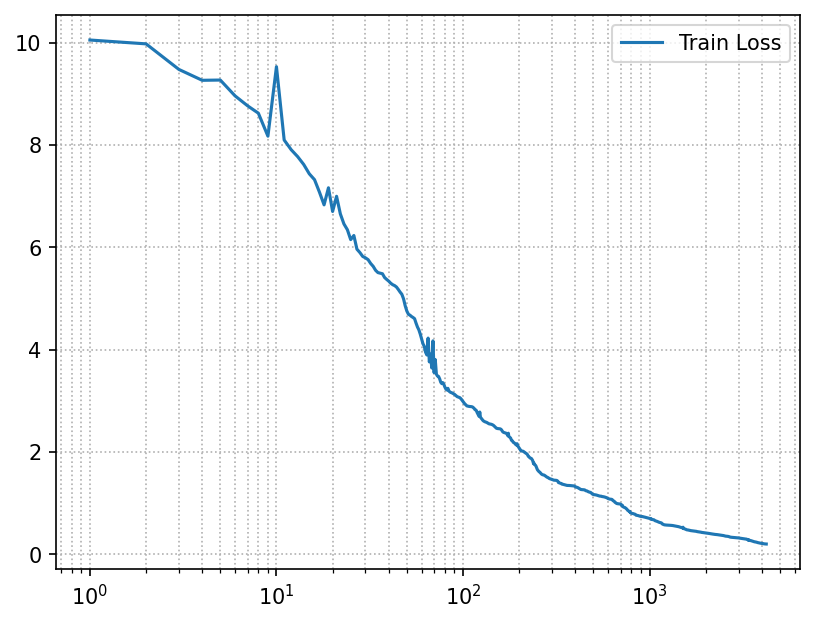

In [7]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

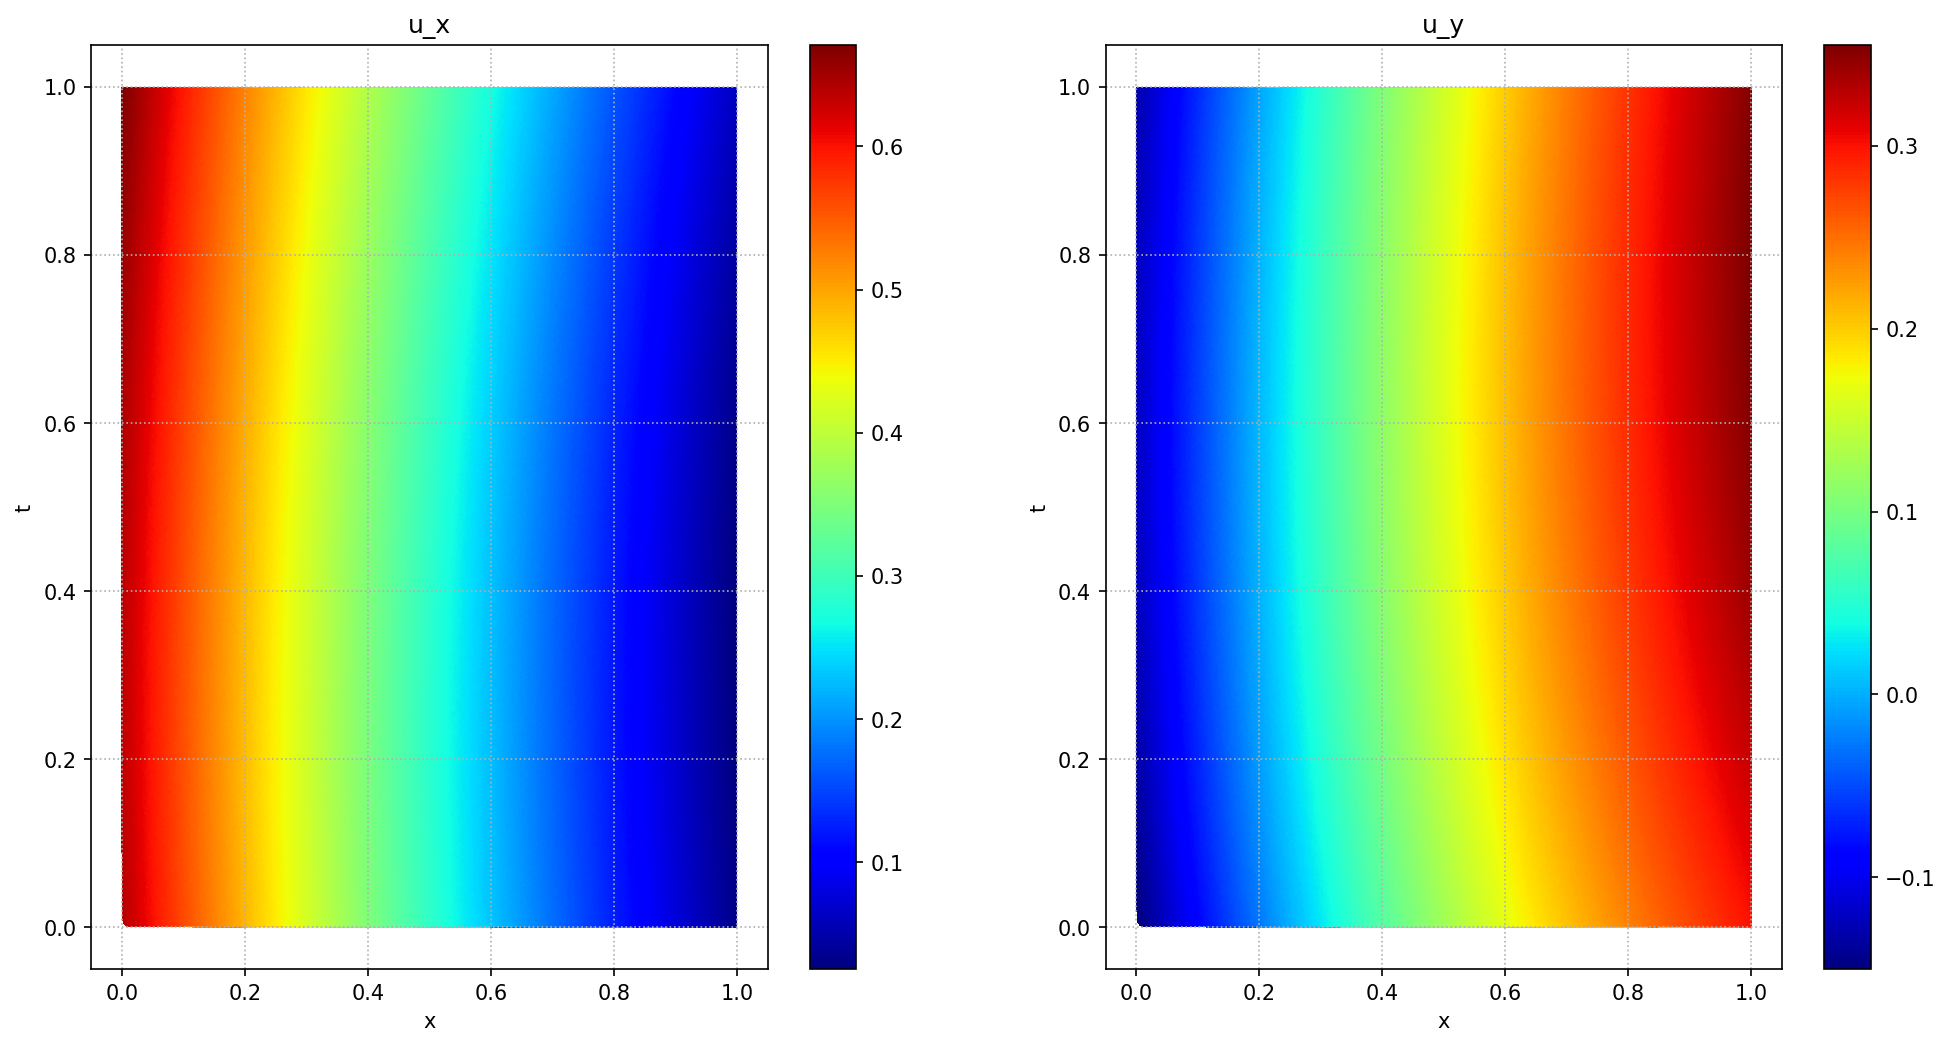

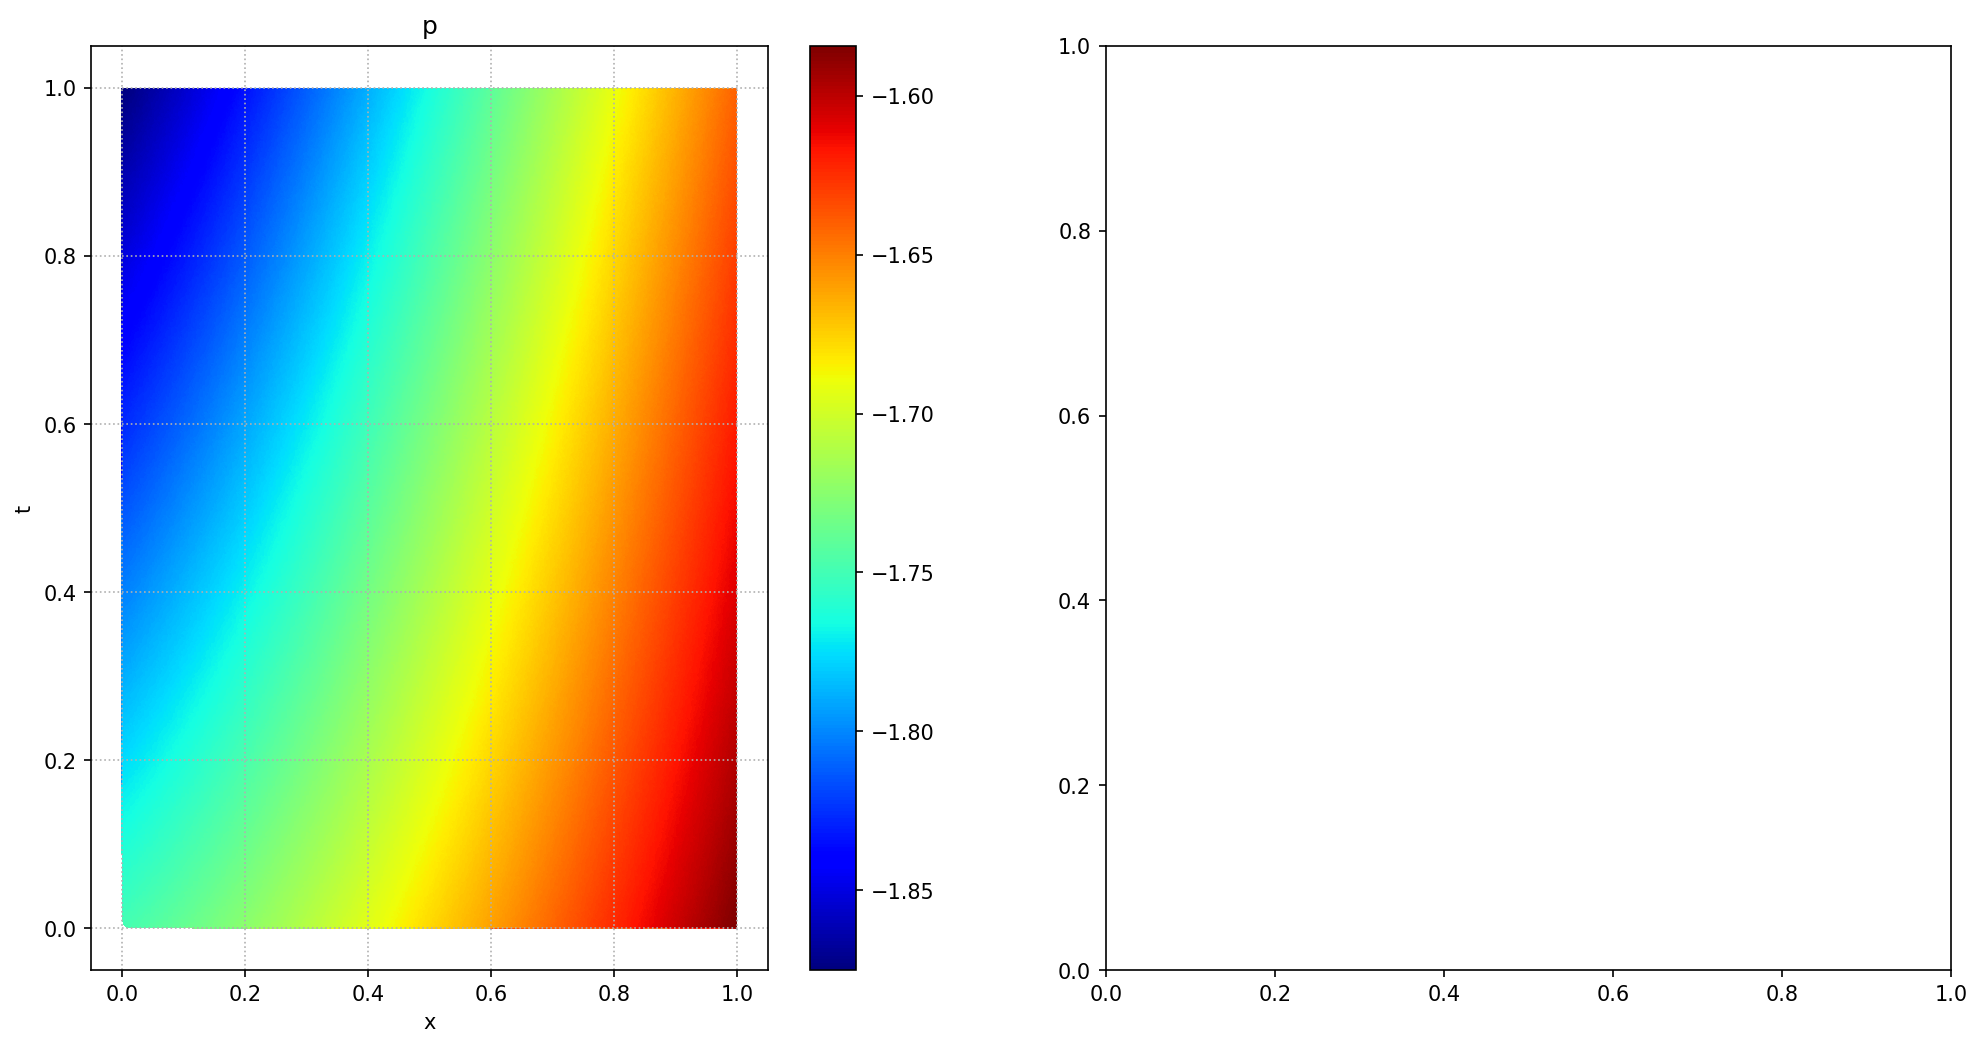

In [8]:
pinn.plotting()